In [1]:
from IPython.display import display, HTML
with open('../style.css') as f:
    css = f.read()
HTML(css)

In [2]:
%load_ext nb_mypy

Version 1.0.5


# Missionaries and Infidels

We illustrate the notion of a search problem with the following example, which is also known as the
<a href="https://en.wikipedia.org/wiki/Missionaries_and_cannibals_problem">missionaries and cannibals problem</a>:
Three *missionaries* and three *infidels* have to cross a river that runs from the north to the south.
Initially, both the missionaries and the infidels are on the western shore.  There is just one small boat and
that boat can carry at most two passengers.  Both the missionaries and the infidels can steer the boat.
However, if at any time the missionaries are confronted with a majority of infidels on either shore of the
river, then the missionaries have a problem. Below is an artist's rendition of the problem.

![Missionaries and Infidels](missionaries-and-infidels.png)

$\texttt{no_problem}(m, i)$ is true if there is no problem on either side.
$m$ and $i$ are the number of missionaries and infidels on the left shore.
Hence there are $3-m$ missionaries and $3-i$ infidels on the right shore.

There is no problem if either all missionaries are on the same side of the river or 
if the number of missionaries is the same as the number of infidels.

In [7]:
def no_problem(M: int, I: int) -> bool: 
    return M == 0 or M == 3 or M == I

A state is represented as a triple.  The triple $(m, i, b)$ specifies that there are
  - $m$ missionaries,
  - $i$ infidels, and
  - $b$ boats

on the *western* shore of the river.  This implies that there are 
$3 - m$ missionaries, $3 - i$ infidels, and $1 - b$ boats on the *eastern* shore.

The type of a state is defined as a triple of integers.

In [3]:
State = tuple[int, int, int]

The function `next_states` takes a given `state` and computes the set of states that can be reached from `state` by crossing the river. 

In [4]:
def next_states(state):
    m, i, b = state
    if b == 1:
        return { (m - mb, i - ib, 0) for mb in range(m+1)
                                     for ib in range(i+1)
                                     if 1 <= mb + ib <= 2 and no_problem(m - mb, i - ib) 
               }
    else:
        return { (m + mb, i + ib, 1) for mb in range(3-m+1)
                                     for ib in range(3-i+1)
                                     if 1 <= mb + ib <= 2 and no_problem(m + mb, i + ib) 
               }

Initially, all missionaries, all infidels and the boat are on the left shore.
The goal is to have everybody on the right shore, hence the numbers on the left shore
should all be $0$.

In [5]:
start = (3, 3, 1)
goal  = (0, 0, 0)

In [8]:
next_states(start)

{(2, 2, 0), (3, 1, 0), (3, 2, 0)}

In order to compute a solution of this search problem, we have to use the notebook `03-Breadth-First-Search.iypnb`, which implements *breadth first search*. 

# Printing the Transition Relation

To begin with, we display the transition relation that is generated by the function `next_states`.  To this end, we need the module `graphviz`.

In [9]:
import graphviz as gv

In [10]:
def tripleToStr(t: State) -> str:
    return '(' + str(t[0]) + ',' + str(t[1]) + ',' + str(t[2]) + ')'

The function `dot_graph(R)` turns a given binary relation `R` into a graph.
We define the type alias `Relation` as a set of pairs of `States`.
Unfortunately, we are not able to specify the return type, as the module `graphviz` is not yet 
equipped with type annotations.

In [11]:
Relation = set[tuple[State, State]]

The function `dot_graph` take a relation `R` and returns a *dot* object that can be displayed.

In [12]:
def dot_graph(R: Relation):
    """This function takes binary relation R as inputs and shows this relation as
       a graph using the module graphviz.
    """
    dot = gv.Digraph()
    dot.attr(rankdir='LR')
    dot.attr(size="12,13")
    Nodes = { tripleToStr(a) for (a,b) in R } | { tripleToStr(b) for (a,b) in R }
    for n in Nodes:
        if   n == '(0,0,0)':
            dot.node(str(n), color='blue', shape='doubleoctagon')
        elif n == '(3,3,1)':
            dot.node(str(n), color='red', shape='doubleoctagon')
        else:
            dot.node(n)
    for (x, y) in R:
        dot.edge(tripleToStr(x), tripleToStr(y))
    return dot

The function call `createRelation(start)` computes the transition relation.  It assumes that all states are reachable from `start`. 

In [13]:
def createRelation(start: State) -> Relation:
    oldM: set[State] = set()
    M:    set[State] = { start }
    R: Relation      = set()
    while True:
        oldM = M.copy()
        M |= { y for x in M
                 for y in next_states(x)
             }
        if M == oldM:
            break
    return { (x, y) for x in M
                    for y in next_states(x)
           }

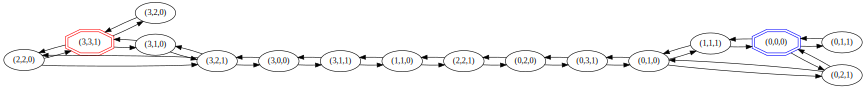

In [14]:
dot_graph(createRelation(start))

## Functions to Print the Solution

In [ ]:
def fillCharsLeft(x: str, n: int) -> str:
    s = str(x)
    m = n - len(s)
    return m * " " + s

In [ ]:
def fillCharsRight(x: str, n: int) -> str:
    s = str(x)
    m = n - len(s)
    return s + m * " "

In [ ]:
def fillCharsBoth(x: str, n: int) -> str:
    s  = str(x)
    ml = (n     - len(s)) // 2
    mr = (n + 1 - len(s)) // 2
    return ml * " " + s + mr * " "

The function `printState(m, k, b)` displays a state where there are `m` missionaries, 
`k` cannibals, and `b` boats on the left shore.

In [ ]:
def printState(m: int, k: int, b: int) -> None:
     print( fillCharsRight(m * "M", 6) + 
            fillCharsRight(k * "K", 6) + 
            fillCharsRight(b * "B", 3) + "    |~~~~~|    " + 
            fillCharsLeft((3 - m) * "M", 6) + 
            fillCharsLeft((3 - k) * "K", 6) + 
            fillCharsLeft((1 - b) * "B", 3) 
          )

The function `printBoat(m1, k1, b1, m2, k2, b2)` prints the boat when there are
`m1` missionaries, `k1` cannibals, and `b1` boats on the left shore before the transition,
while there `m2` missionaries, `k2` cannibals, and `b2` boats on the left shore after the transition.
The function also checks whether the transition is possible at all.

In [ ]:
def printBoat(m1: int, k1: int, b1: int, m2:int, k2: int, b2: int) -> None:
    if b1 == 1:
        if m1 < m2:
            print("Error in printBoat: negative number of missionaries in the boat!")
            return
        if k1 < k2:
            print("Error in printBoat: negative number of infidels in the boat!")
            return
        print(19*" " + "> " + fillCharsBoth((m1-m2)*"M" + " " + (k1-k2)*"K", 3) + " >")
    else:
        if m1 > m2:
            print("Error in printBoat: negative number of missionaries in the boat!")
            return
        if k1 > k2:
            print("Error in printBoat: negative number of infidels in the boat!")
            return
        print(19*" " + "< " + fillCharsBoth((m2-m1)*"M" + " " + (k2-k1)*"K", 3) + " <")

The function call `printPath(Path)` prints the solution of the search problem.

In [ ]:
def printPath(Path: list[State]) -> None:
    print("Solution:\n")
    for i in range(len(Path) - 1):
        m1, k1, b1 = Path[i]
        m2, k2, b2 = Path[i+1]
        printState(m1, k1, b1)
        printBoat(m1, k1, b1, m2, k2, b2)
    m, k, b = Path[-1]
    printState(m, k, b)